In [86]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings 
warnings.filterwarnings('ignore')

In [66]:
data = pd.read_csv('AirPassengers.csv')

In [67]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [68]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [69]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),1))
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [70]:
data['Month'].head()

0   1949-01-01
1   1949-02-01
2   1949-03-01
3   1949-04-01
4   1949-05-01
Name: Month, dtype: datetime64[ns]

In [71]:
data = data.set_index('Month')

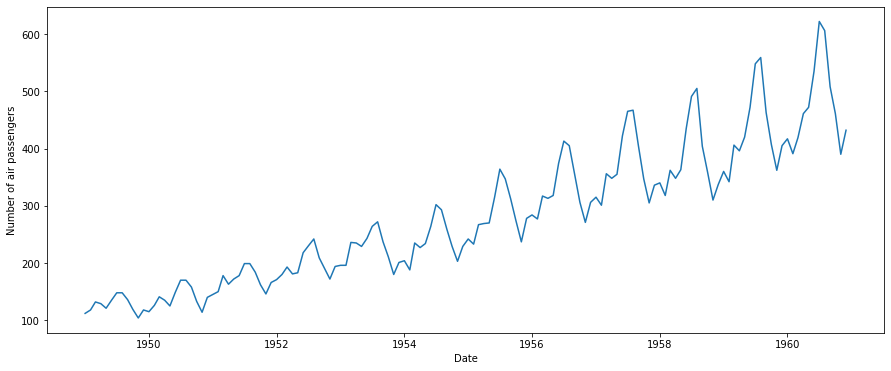

In [73]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(data)

In [75]:
#Determine rolling statistics
rolmean = data.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = data.rolling(window=12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


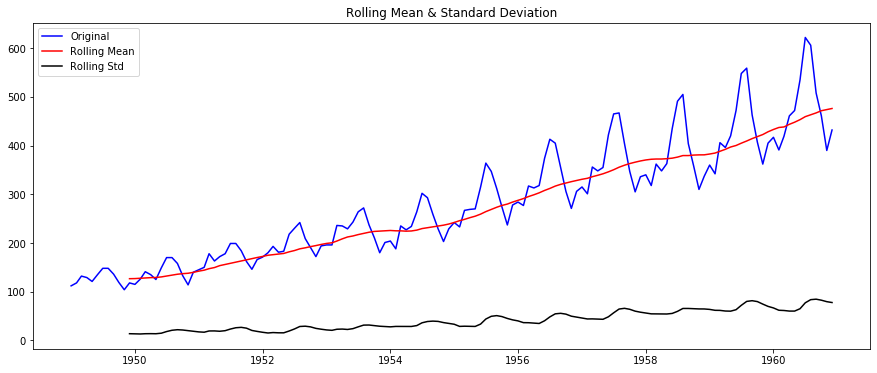

In [77]:
#Plot rolling statistics
orig = plt.plot(data, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [78]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

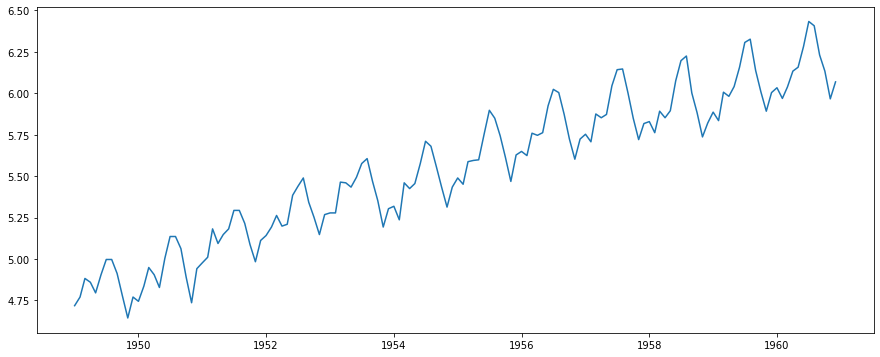

In [79]:
#Data transformation to achieve stationarity- objective remove trend component

#Estimating trend
data_logScale = np.log(data)
plt.plot(data_logScale)

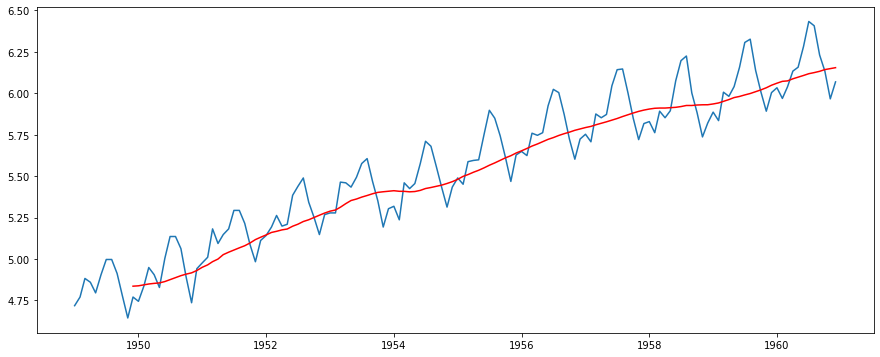

In [80]:
#The below transformation is required to make series stationary
movingAverage = data_logScale.rolling(window=12).mean()
movingSTD = data_logScale.rolling(window=12).std()
plt.plot(data_logScale)
plt.plot(movingAverage, color='red')

In [81]:
datasetLogScaleMinusMovingAverage = data_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [82]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

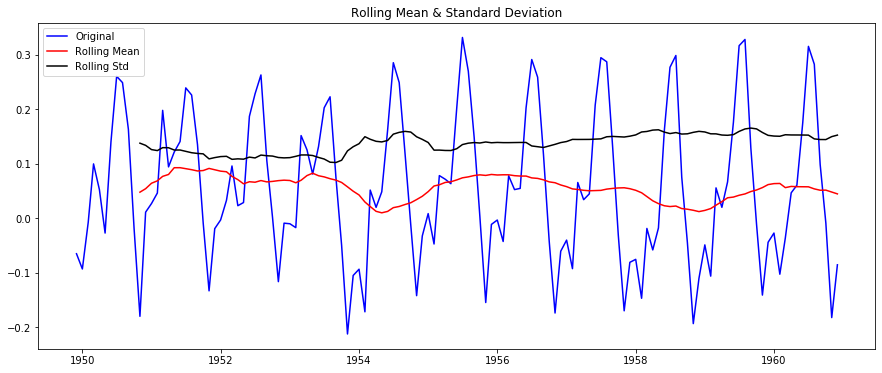

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [83]:
test_stationarity(datasetLogScaleMinusMovingAverage)

In [91]:
decomposition = seasonal_decompose(data_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

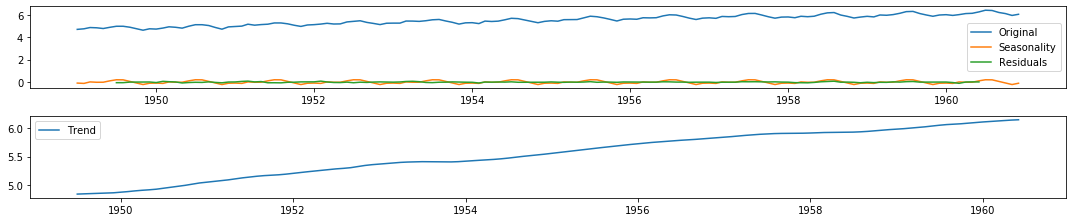

In [98]:
plt.subplot(411)
plt.plot(data_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

Text(0.5, 1.0, 'Autocorrelation Function')

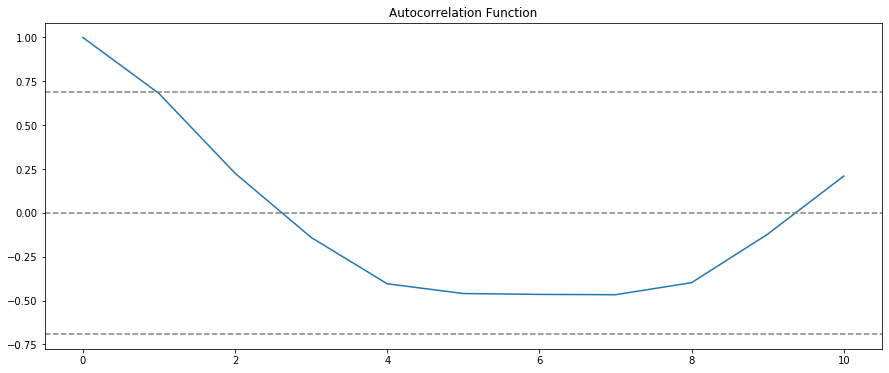

In [109]:
#ACF 

plt.plot(np.arange(0,11), acf(datasetLogScaleMinusMovingAverage, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')  

Text(0.5, 1.0, 'Partil cAutocorrelation Function')

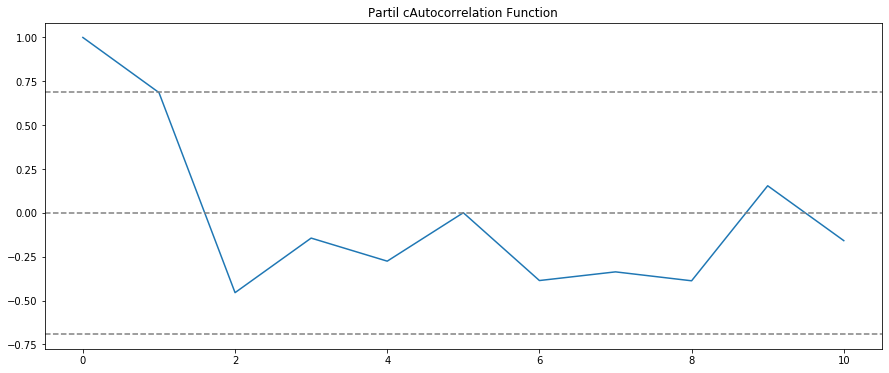

In [111]:
#PCF

plt.plot(np.arange(0,11), pacf(datasetLogScaleMinusMovingAverage, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(datasetLogScaleMinusMovingAverage)), linestyle='--', color='gray')
plt.title('Partil cAutocorrelation Function') 

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

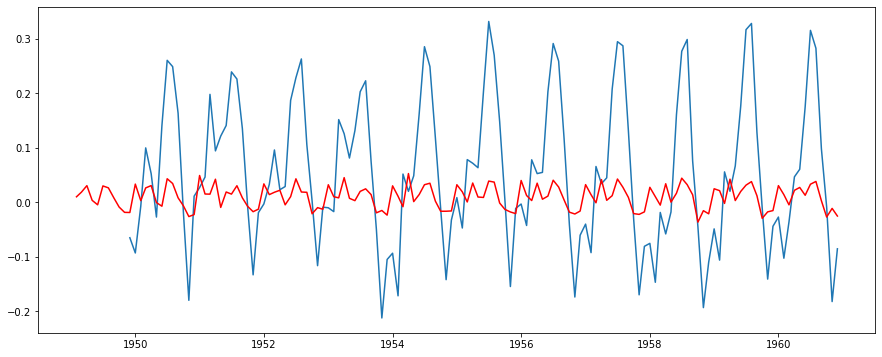

In [115]:
#AR Model
model = ARIMA(data_logScale, order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogScaleMinusMovingAverage)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogScaleMinusMovingAverage)**2))
print('Plotting AR model')

In [117]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009676
1949-03-01    0.018164
1949-04-01    0.030130
1949-05-01    0.003154
1949-06-01   -0.005039
dtype: float64


In [118]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009676
1949-03-01    0.027839
1949-04-01    0.057969
1949-05-01    0.061123
1949-06-01    0.056084
                ...   
1960-08-01    1.420641
1960-09-01    1.423181
1960-10-01    1.395705
1960-11-01    1.384064
1960-12-01    1.358414
Length: 143, dtype: float64


In [120]:
predictions_ARIMA_log = pd.Series(data_logScale['#Passengers'].iloc[0], index=data_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728175
1949-03-01    4.746338
1949-04-01    4.776468
1949-05-01    4.779622
dtype: float64

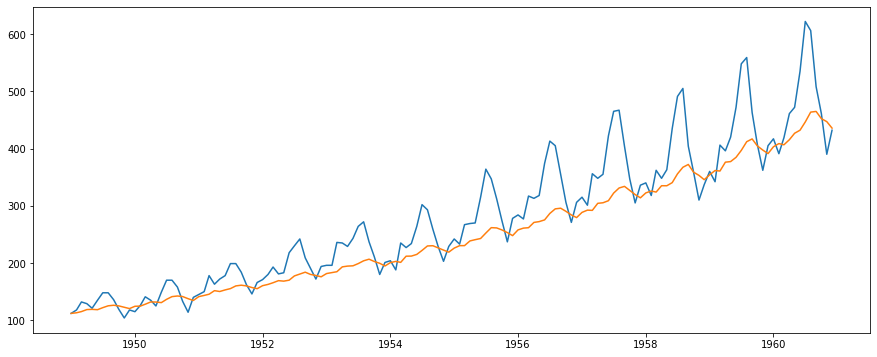

In [121]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)